# Imports

In [ ]:
!pip install sklearn --upgrade

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Loading data

In [2]:
employee = pd.read_csv(os.path.join("..","..", "data","attrition", "employee_process.csv"))

In [3]:
y=employee['y']
X=employee.drop(columns=['y'])

### Split into train and test subsample

In [4]:
from sklearn.model_selection import train_test_split
# Use the normalized data : Xn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1176, 49)
(1176,)
(294, 49)
(294,)


In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#X_train = pd.DataFrame(X_train, columns=X.columns)
#X_test = pd.DataFrame(X_test, columns=X.columns)

# Defition of the metrics function 

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [26]:
def recall_precision(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    y_pred2= np.where(y_pred <= optimal_threshold , 0, 1)
    cm = confusion_matrix(y_test, y_pred2)
    print("Confusion matrix \n" , cm)
    precision = cm[1,1]/sum(cm[:,1])
    print("\nPrecision : " + str(precision))
    recall = cm[1,1]/sum(cm[1,:])
    print("Recall : " + str(recall))
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 : " + str(f1))
    
def recall_precision_bi (X_test,y_test,y_pred,model):
    PrecisionRecallDisplay.from_estimator(model,X_test, y_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix \n" , cm)
    f1 = f1_score(y_test, y_pred, average='binary')
    print("F1 : " + str(f1))

# OLS

In [9]:
model = LinearRegression().fit(X_train, y_train)
y_ols = model.predict(X_test)

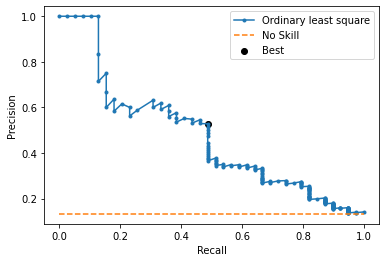


TEST
Best Threshold=0.399414, F-Score=0.507
Confusion matrix 
 [[239  16]
 [ 21  18]]

Precision : 0.5294117647058824
Recall : 0.46153846153846156
F1 : 0.4931506849315069


In [23]:
recall_precision(y_test,y_ols,'Ordinary least square')

In [82]:
y_ols2= np.where(y_ols <= 0.399414 , 0, 1)

# Logistic regression

In [11]:
clf = LogisticRegression().fit(X_train, y_train)
y_log = clf.predict(X_test)

Confusion matrix 
 [[248   7]
 [ 25  14]]
F1 : 0.4666666666666667


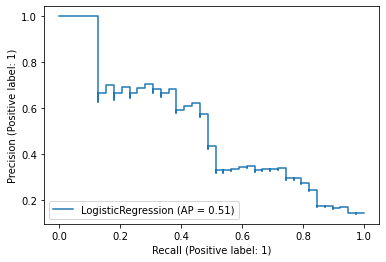

In [27]:
recall_precision_bi(X_test,y_test,y_log,clf)

In [28]:
'''sort = clf.coef_[0].argsort()
sort = sort[-10:]
plt.barh(X_train.columns[sort], clf.coef_[0][sort])
plt.xlabel("Feature Importance")
plt.show()'''

'sort = clf.coef_[0].argsort()\nsort = sort[-10:]\nplt.barh(X_train.columns[sort], clf.coef_[0][sort])\nplt.xlabel("Feature Importance")\nplt.show()'

# Classification tree

In [14]:
dtc_fit = DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
y_tree = dtc_fit.predict(X_test)

Confusion matrix 
 [[218  37]
 [ 31   8]]
F1 : 0.19047619047619047


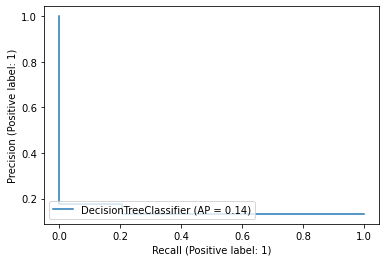

In [29]:
recall_precision_bi(X_test,y_test,y_tree,dtc_fit)

There is overfitting since the accuracy on the train subset is 100%, the model has over learned on the data it trained with. We need to optimize the tree by "pruning" it. 
We look at all the potential hyperparamter that can be tuned :
- max_depth : max nb of levels in each decision tree
- min_sample_split : min nb of data points placed in a node 
- min_sample_leaf : min nb of data points in a node leaf
- criterion : a measure of the attribute selection
- Splitter : the split strategy

In [30]:
from sklearn.model_selection import RandomizedSearchCV
print('Parameters currently in use:\n')
dtc_fit.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [31]:
# Atribute selection measure
criterion = ['gini', 'entropy']
# Split strategy
splitter = ['best', 'random']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'criterion': criterion,
               'splitter' : splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_grid

{'criterion': ['gini', 'entropy'],
 'splitter': ['best', 'random'],
 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [32]:
dtc_random = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
dtc_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 31, 52, 73, 94, 115,
                                                      136, 157, 178, 200],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   random_state=42, verbose=2)

In [33]:
dtc_random.best_params_

{'splitter': 'random',
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'gini'}

In [34]:
dtc_fit2 = DecisionTreeClassifier(random_state=42,
                                  criterion='gini',
                                  max_depth = 10,
                                  min_samples_leaf = 2,
                                  min_samples_split = 5,
                                  splitter = 'random').fit(X_train,y_train)
y_tree2 = dtc_fit2.predict(X_test)

Confusion matrix 
 [[233  22]
 [ 29  10]]
F1 : 0.28169014084507044


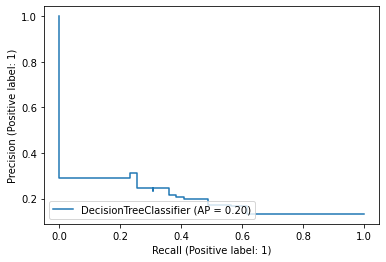

In [35]:
recall_precision_bi(X_test,y_test,y_tree2,dtc_fit2)

# Random forest

In [38]:
rf_fit = RandomForestClassifier(random_state=42).fit(X_train,y_train)
y_rf = rf_fit.predict(X_test)

Confusion matrix 
 [[254   1]
 [ 35   4]]
F1 : 0.18181818181818182


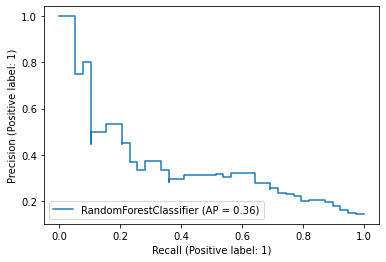

In [39]:
recall_precision_bi(X_test,y_test,y_rf,rf_fit)

There is overfitting, we tune the hyperparameter to asses a better estimator.
We look at all the potential hyperparamter that can be tuned.
We will first tune :
- n_estimators : nb of trees in the forest
- max_features : max nb of features for spliting a node (as random subset are use) // Usually sqrt for classification and divided by 3 for regression
- max_depth : max nb of levels in each decision tree
- min_sample_split : min nb of data points placed in a node 
- min_sample_leaf : min nb of data points in a node leaf


In [40]:
rf = RandomForestClassifier(random_state=42)
from sklearn.model_selection import RandomizedSearchCV
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

This allows for 11*2*3*3*10 = 1980 possible settings, thus we use a random search cross-validation. It means that we will determine a number of maximum random settings to test, here 100, and test it trhought a 3 fold cross-validation.

In [42]:
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [43]:
rf_random.best_params_

{'n_estimators': 733,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100}

In [44]:
rf_fit2 = RandomForestClassifier(n_estimators=733,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 max_features='auto',
                                 max_depth = 100,
                                random_state=42)
rf_fit2.fit(X_train,y_train)
y_rf2 = rf_fit2.predict(X_test)

Confusion matrix 
 [[254   1]
 [ 35   4]]
F1 : 0.18181818181818182


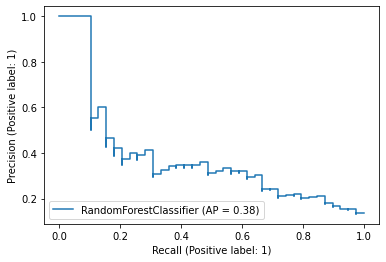

In [46]:
recall_precision_bi(X_test,y_test,y_rf2,rf_fit2)

In [ ]:
sort = rf_fit2.feature_importances_.argsort()
sort = sort[-10:]
plt.barh(X_train.columns[sort], rf_fit2.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.figure(figsize=(5,20))
plt.show()

# Support vector machine (SVM)

In [60]:
svc = SVC(kernel = 'linear', random_state = 0, probability = True)
svc.fit(X_train, y_train)
y_svm = svc.predict(X_test)

Confusion matrix 
 [[247   8]
 [ 22  17]]
F1 : 0.53125


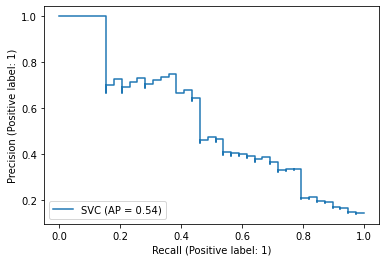

In [61]:
recall_precision_bi(X_test,y_test,y_svm,svc)

# Model comparaisons

### Using PrecisionRecallDisplay.**from_estimators**

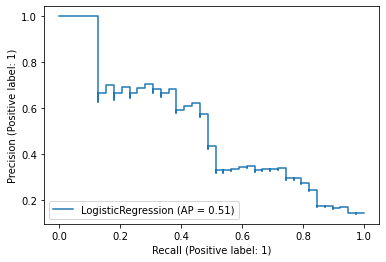

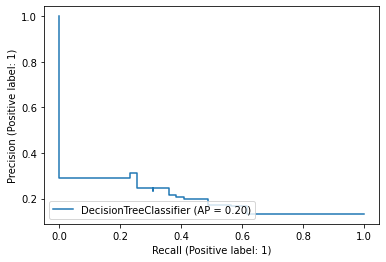

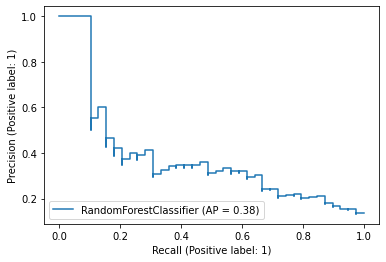

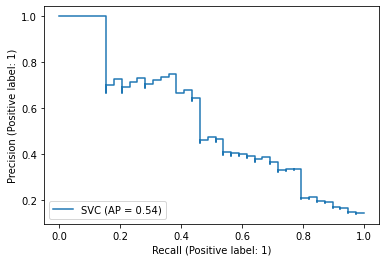

In [84]:
PC_logistic = PrecisionRecallDisplay.from_estimator(clf,X_test,y_test)
PC_tree = PrecisionRecallDisplay.from_estimator(dtc_fit2,X_test,y_test)
PC_rf = PrecisionRecallDisplay.from_estimator(rf_fit2,X_test,y_test)
PC_svm = PrecisionRecallDisplay.from_estimator(svc,X_test,y_test)

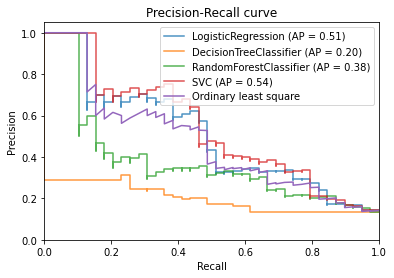

<Figure size 360x576 with 0 Axes>

In [63]:
ax = plt.gca()
PC_logistic.plot(ax=ax, alpha=0.8)
PC_tree.plot(ax=ax, alpha=0.8)
PC_rf.plot(ax=ax, alpha=0.8) 
PC_svm.plot(ax=ax, alpha=0.8) 
precision, recall, thresholds = precision_recall_curve(y_test,y_ols)
recall_plot = plt.plot(recall, precision, marker='', label='Ordinary least square')
#plt.plot([0, 0], [1, 1], color="darkorange", linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc="upper right", fontsize = 10)
plt.figure(figsize=(5,8))
plt.show()

In [85]:
 f_score = pd.DataFrame({
    'Algorithm' : ['OLS','Logistic','Tree','Random forest','SVM'],
    'y_pred' : [y_ols2,y_log,y_tree2,y_rf2,y_svm]
})
f_score

,Algorithm,y_pred
0,OLS,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,Logistic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Tree,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,Random forest,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,SVM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [86]:
f1_list = []
for index, row in f_score.iterrows():
    f1 = f1_score(y_test, row['y_pred'], average='binary')
    f1_list.append(f1)

In [89]:
f_score['f1']=f1_list
f_score.sort_values(by=['f1'],ascending=False)

,Algorithm,y_pred,f1
4,SVM,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.531250
0,OLS,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.506667
1,Logistic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.466667
2,Tree,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.281690
3,Random forest,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.181818
